# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers embedding of nodes and edges using Node2vec (as well as its hyperparameter tuning)

### 1. Import Packages

In [86]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)
reload(n2v)

<module 'util.node2vec' from 'c:\\Users\\pbedi\\Documents\\GitHub\\Network-Science_Challenge\\util\\node2vec.py'>

In [80]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc
import util.node2vec as n2v

In [48]:
# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# hyperparameter tuning
from ray import tune, air
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler, MedianStoppingRule, PopulationBasedTraining
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.experiment.trial import Trial

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# node2vec
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

# modeling
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import PredefinedSplit

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [67]:
# might take up to a minute
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf) = loadData.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


In [5]:
# where to save trial results to
ray_path = os.path.abspath("")+"\\ray_results\\"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

### 3. Node2vec Embedding

#### 3.1 Hyperparameter tuning

In [7]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # log params in raytune
    "ray": True,
    
    # basic infos
    "model": "node2vec",
    "graph": G_train,
    "trainval_tf": trainval_tf,
    "val_tf": val_tf,
    "trainval_idx": trainval_tf.index,
    "val_idx": val_tf.index,
    'val_fold': [0 if i in val_tf.index else -1 for i in trainval_tf.index],
    "save": True, # if we want to save best model on validation set
    
    ## node2vec
    "dimensions": tune.grid_search([1, 2, 4]),
    "walk_length": 80,
    "num_walks": 10,
    "p": tune.grid_search([0.25, 0.5, 0.75, 1, 1.25, 1.5]),
    "q": tune.grid_search([0.25, 0.5, 0.75, 1, 1.25, 1.5]),
    
    # edge embedding operator
    "operator": tune.grid_search([HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder])
}

In [10]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = n2v.run_ray_experiment(
    n2v.train_validate, config, ray_path, num_samples,
    metric_columns = ["acc_train", "acc_val"],
    parameter_columns = ["dimensions", "p", "q", "operator"]
)

#### 3.2 Result of Hyperparameter tuning

In [8]:
restored_tuner, result_grid = n2v.open_validate_ray_experiment(
    "ray_results/train_validate_2023-03-26_04-19-57",
    n2v.train_validate
)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Loading results from ray_results/train_validate_2023-03-26_04-19-57...
Done!

No errors! Number of terminated trials: 368


In [12]:
# get best score per trial (highest validation accuracy)
N = 10
best_result_df = result_grid.get_dataframe(
    filter_metric="acc_val", filter_mode="max"
)
best_result_df = best_result_df[["trial_id",
                                 'config/dimensions', 'config/p', 'config/q', 'config/operator',
                                 "acc_train", "acc_val"]]
best_result_df = best_result_df.sort_values(by=["acc_val"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

Couldn't read config from 16 paths


,trial_id,config/dimensions,config/p,config/q,config/operator,acc_train,acc_val
59,b78dc_00059,4,1.25,0.25,<class 'node2vec.edges.WeightedL2Embedder'>,0.819685,0.644529
35,b78dc_00035,4,0.75,0.25,<class 'node2vec.edges.WeightedL2Embedder'>,0.819207,0.643574
275,b78dc_00275,4,1.25,1.00,<class 'node2vec.edges.WeightedL2Embedder'>,0.823794,0.642140
23,b78dc_00023,4,0.50,0.25,<class 'node2vec.edges.WeightedL2Embedder'>,0.820449,0.641663
68,b78dc_00068,4,1.50,0.25,<class 'node2vec.edges.WeightedL1Embedder'>,0.832871,0.640707
71,b78dc_00071,4,1.50,0.25,<class 'node2vec.edges.WeightedL2Embedder'>,0.812040,0.640707
128,b78dc_00128,4,1.25,0.50,<class 'node2vec.edges.WeightedL1Embedder'>,0.836120,0.639752
311,b78dc_00311,4,0.50,1.25,<class 'node2vec.edges.WeightedL2Embedder'>,0.825514,0.638318
143,b78dc_00143,4,1.50,0.50,<class 'node2vec.edges.WeightedL2Embedder'>,0.814907,0.638318
140,b78dc_00140,4,1.50,0.50,<class 'node2vec.edges.WeightedL1Embedder'>,0.836216,0.637840


#### 3.3 Embeddings based on best model

In [58]:
# precompute probabilities and generate walks
node2vec = Node2Vec(G_train, dimensions=4, walk_length=80, num_walks=10, workers=1, p=1.25, q=0.25)

# embed nodes
model = node2vec.fit(window=10)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


In [68]:
# edge embedding
l2_edges_embs = WeightedL2Embedder(keyed_vectors=model.wv)
trainval_edge_embs = pd.DataFrame([l2_edges_embs[(str(u), str(v))] for u, v in zip(config["trainval_tf"].node1, config["trainval_tf"].node2)], index=config["trainval_idx"])
trainval_edge_embs = pd.DataFrame(trainval_edge_embs).rename(columns = {val: f"n{val+1}" for val in range(trainval_edge_embs.shape[1])})
val_edge_embs = pd.DataFrame([l2_edges_embs[(str(u), str(v))] for u, v in zip(config["val_tf"].node1, config["val_tf"].node2)], index=config["val_idx"])
val_edge_embs = pd.DataFrame(val_edge_embs).rename(columns = {val: f"n{val+1}" for val in range(val_edge_embs.shape[1])})
test_edge_embs = pd.DataFrame([l2_edges_embs[(str(u), str(v))] for u, v in zip(test_tf.node1, test_tf.node2)], index=test_tf.index)
test_edge_embs = pd.DataFrame(test_edge_embs).rename(columns = {val: f"n{val+1}" for val in range(test_edge_embs.shape[1])})

Text(0.5, 1.0, 'Node2vec projection (2 dims) of edges')

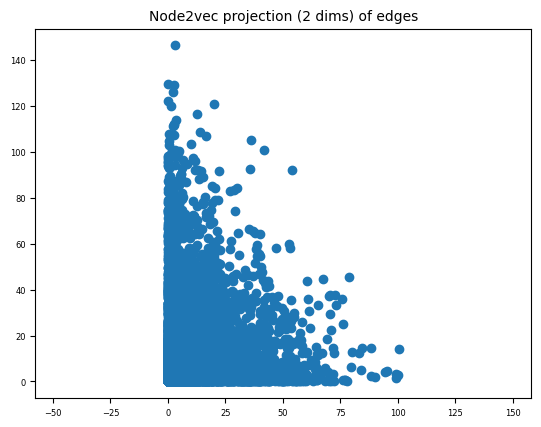

In [60]:
# plot embedding over 2 of its 4 dimensions
plt.scatter(
    trainval_edge_embs[["n2"]],
    trainval_edge_embs[["n4"]]),
plt.gca().set_aspect('equal', 'datalim')
plt.title('Node2vec projection (2 dims) of edges')

In [69]:
# enrich edgelist
trainval_tf = pd.concat([config["trainval_tf"], trainval_edge_embs], axis=1)
val_tf = pd.concat([config["val_tf"], val_edge_embs], axis=1)
test_tf = pd.concat([test_tf, test_edge_embs], axis=1)
X_trainval, y_trainval = loadData.split_frame(trainval_tf)
X_val, y_val = loadData.split_frame(val_tf)
X_test = loadData.split_frame(test_tf)

#### 3.4 Predict edges based on best model

In [70]:
# prepare predefined split for cv
val_fold = [0 if i in X_val.index else -1 for i in X_trainval.index]
ps = PredefinedSplit(val_fold)

# fit logistic 
clf = LogisticRegressionCV(max_iter = 10000, cv = ps)
clf.fit(X_trainval, y_trainval)

# predict on train set
y_train_hat = clf.predict(X_trainval)
# compute accuracy
acc_train = accuracy_score(y_trainval, y_train_hat)

# predict on validation set
y_val_hat = clf.predict(X_val)
# compute accuracy
acc_val = accuracy_score(y_val, y_val_hat)

# print performance (train)
print(f"Acc train: {acc_train}")
print(f"Acc val: {acc_val}")

Acc train: 0.8150023889154324
Acc val: 0.6402293358815098


In [71]:
# predict test
y_test_hat = clf.predict(X_test)

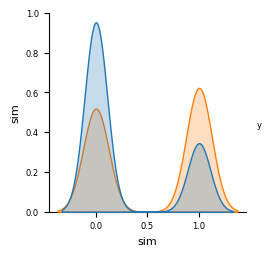

In [74]:
# plot node2vec similarity vs y
tmp = (val_tf
    .assign(sim  = y_val_hat)
    .assign(y = y_val)
)
sns.pairplot(tmp[["sim", "y"]], hue = "y")